In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip uninstall keras-preprocessing
!pip install git+https://github.com/keras-team/keras-preprocessing.git

  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-hlkmgg99
  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-hlkmgg99
  Resolved https://github.com/keras-team/keras-preprocessing.git to commit 3e380065d4afc7347aaee8d89325a16b22158438
  Preparing metadata (setup.py) ... - done
  Created wheel for Keras-Preprocessing: filename=Keras_Preprocessing-1.1.2-py3-none-any.whl size=43632 sha256=a4a74ecb78b4cc8e9218f124cb9cb8b92a7554277bf04bb6c86b7a6607318883
  Stored in directory: /tmp/pip-ephem-wheel-cache-nk2t00c_/wheels/6d/8c/1d/f7c16ffd97b199cf4a20b04f1b9444a9390272edafb52c45f7
Successfully built Keras-Preprocessing


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras_preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers
import cv2
import os

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [5]:
train_df=pd.read_csv("/kaggle/input/early-detection-of-3d-printing-issues/train.csv",dtype=str)

In [6]:
train_df['printer_id'].value_counts()

102    22670
104    20766
101    20205
103     9927
022     7492
Name: printer_id, dtype: int64

In [7]:
val_df = train_df[train_df['printer_id']=='022']

In [8]:
val_df.shape

(7492, 4)

In [9]:
train_df = train_df[train_df['printer_id']!='022']

In [10]:
datagen=ImageDataGenerator(rescale=1./255.,
        rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

train_generator=datagen.flow_from_dataframe(
dataframe=train_df,
directory="/kaggle/input/early-detection-of-3d-printing-issues/images/",
x_col="img_path",
y_col="has_under_extrusion",
batch_size=16,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(256,256))

valid_generator=datagen.flow_from_dataframe(
dataframe=val_df,
directory="/kaggle/input/early-detection-of-3d-printing-issues/images/",
x_col="img_path",
y_col="has_under_extrusion",
batch_size=16,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(256,256))

Found 73568 validated image filenames belonging to 2 classes.
Found 7492 validated image filenames belonging to 2 classes.


In [11]:
def create_resnet_binary_classification_model(input_shape=(256, 256, 3)):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='sigmoid')(x)
    x = Dense(16, activation='sigmoid')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

model = create_resnet_binary_classification_model()
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy','mse'])

94765736/94765736 [==============================] - 3s 0us/step


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [13]:
my_callbacks = [ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)]

history1 = model.fit(x = train_generator, validation_data = valid_generator, epochs = 13, verbose=1, callbacks=my_callbacks)

Epoch 1/13
4598/4598 [==============================] - 2525s 541ms/step - loss: 0.2617 - accuracy: 0.8930 - mse: 0.0791 - val_loss: 2.6858 - val_accuracy: 0.4074 - val_mse: 0.5614
Epoch 2/13
4598/4598 [==============================] - 2301s 500ms/step - loss: 0.0882 - accuracy: 0.9679 - mse: 0.0243 - val_loss: 0.8608 - val_accuracy: 0.7029 - val_mse: 0.2285
Epoch 3/13
4598/4598 [==============================] - 2276s 495ms/step - loss: 0.0562 - accuracy: 0.9801 - mse: 0.0152 - val_loss: 2.0909 - val_accuracy: 0.4554 - val_mse: 0.4600
Epoch 4/13
4598/4598 [==============================] - 2168s 471ms/step - loss: 0.0432 - accuracy: 0.9845 - mse: 0.0117 - val_loss: 2.1345 - val_accuracy: 0.5167 - val_mse: 0.4263
Epoch 5/13
4598/4598 [==============================] - 2144s 466ms/step - loss: 0.0346 - accuracy: 0.9884 - mse: 0.0091 - val_loss: 2.5381 - val_accuracy: 0.4175 - val_mse: 0.5443
Epoch 6/13
4598/4598 [==============================] - 2167s 471ms/step - loss: 0.0291 - accur

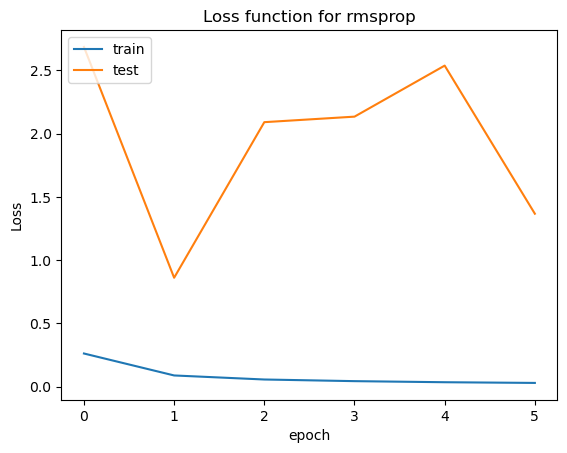

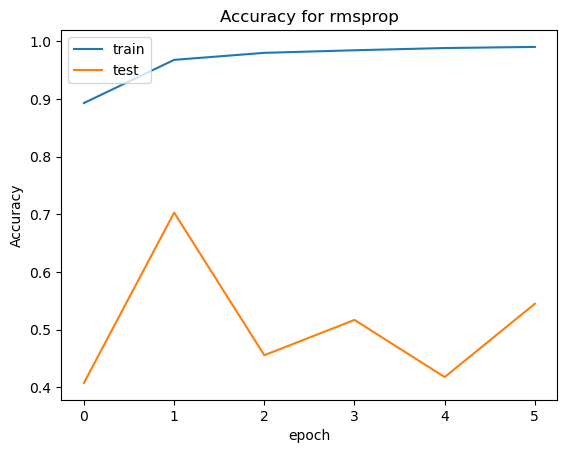

In [14]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Loss function for rmsprop')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Accuracy for rmsprop')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
import sklearn

predictions = model.predict(valid_generator) 
predicted_classes = np.argmax(predictions, axis=1)
#y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(sklearn.metrics.confusion_matrix(valid_generator.classes, predicted_classes))

469/469 [==============================] - 208s 441ms/step
Confusion Matrix
[[4432    0]
 [3060    0]]
